In [18]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, CartesianRepresentation, ICRS, GCRS,UnitSphericalRepresentation
# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')
from pyipn.io.plotting.projection import *

from pyipn.geometry import Location
from pyipn.io.plotting.spherical_circle import SphericalCircle
#import stan_utility

green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"
from mpl_toolkits.mplot3d import Axes3D 

from pyipn import copy_template, Universe
import cmdstanpy
import arviz as av
import ipyvolume as ipv

In [2]:
uni = Universe.from_yaml('template_config.yaml')
uni.explode_grb(tstart=-50,tstop=100)
print(uni._T0)
uni.plot_all_annuli(cmap='Set1_r',lw=1, threeD=True);

[0.         0.46060308]


<IPython.core.display.Javascript object>


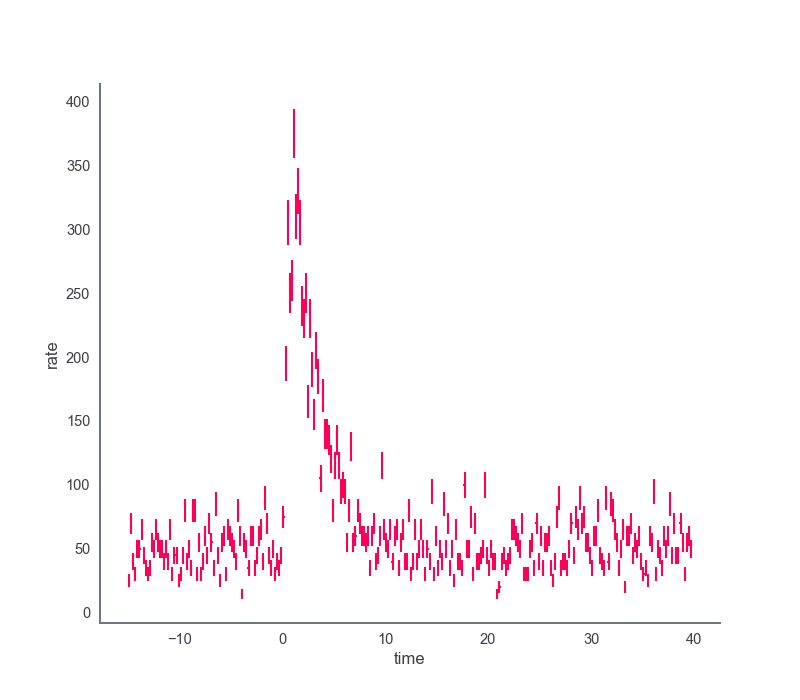

<IPython.core.display.Javascript object>


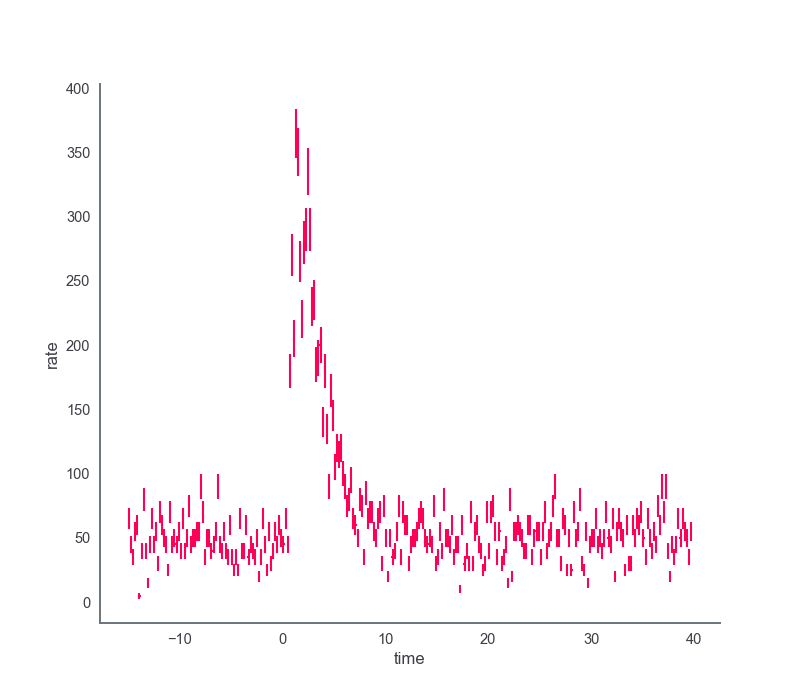

In [3]:
for det, lc in uni.light_curves.items():

    lc.display(-15,40,.2,color=red)

    
d1 = uni.detectors['det1']
d2 = uni.detectors['det2']

xyz1=d1.location.get_cartesian_coord().xyz.value

xyz2= d2.location.get_cartesian_coord().xyz.value

In [31]:
uni._time_differences

array([0.        , 0.46060308])

In [32]:
uni._grb.location.coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, Mpc)
    (110., -3., 500.)>

In [5]:
lc = uni.light_curves['det1']
counts, times = lc.get_binned_light_curve(-10.1,30.,.2)
mid = np.mean([times[:-1],times[1:]], axis=0)
width = times[1:] - times[:-1]




lc2 = uni.light_curves['det2']

counts2, times2 = lc2.get_binned_light_curve(-10,30,.2)
mid2 = np.mean([times2[:-1],times2[1:]], axis=0)
width2 = times2[1:] - times2[:-1]
k=50
k2=25
N_model = 200

predict_time = np.linspace(-20,40,N_model)
omega=np.random.randn(k)
omega2=np.random.randn(k2)


data = dict(N1=len(counts),
            time1=mid,
            counts1=counts.astype(int),
            exposure1=width,
            exposure2=width2,
            N2=len(counts2),
            time2=mid2,
            counts2=counts2.astype(int),
            k=k,
            k2=k2,
            bw=.7,
            omega=omega,
             omega2=omega2,
            N_model=N_model,
            predict_time=predict_time,
            
            sc_pos1 = xyz1,
            sc_pos2 = xyz2,
            grainsize=1
           
           
           
           )

In [45]:
uni._time_differences

array([0.        , 0.46060308])

In [8]:
import os

In [9]:
model = cmdstanpy.CmdStanModel(stan_file="rff_para.stan", cpp_options={'STAN_THREADS': 'TRUE'})

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/jburgess/sw/pyipn/prototype/rff_para


In [10]:
warmup = 1000
samp = 500
os.environ["STAN_NUM_THREADS"] = "24"

# fit = model.sampling(warmup=500,iter=750,data=data, chains=4, seed=1234,
#                      control = dict(max_treedepth=13, adapt_delta=.9))


fit = model.sample(
    data=data,
    cores=48,
    iter_warmup=warmup,
    iter_sampling=samp,
    chains=2,
    max_treedepth=10,
    show_progress="notebook",
#    metric="diag_e",
    seed=16574)



In [11]:
ar = av.from_cmdstanpy(fit)

<IPython.core.display.Javascript object>


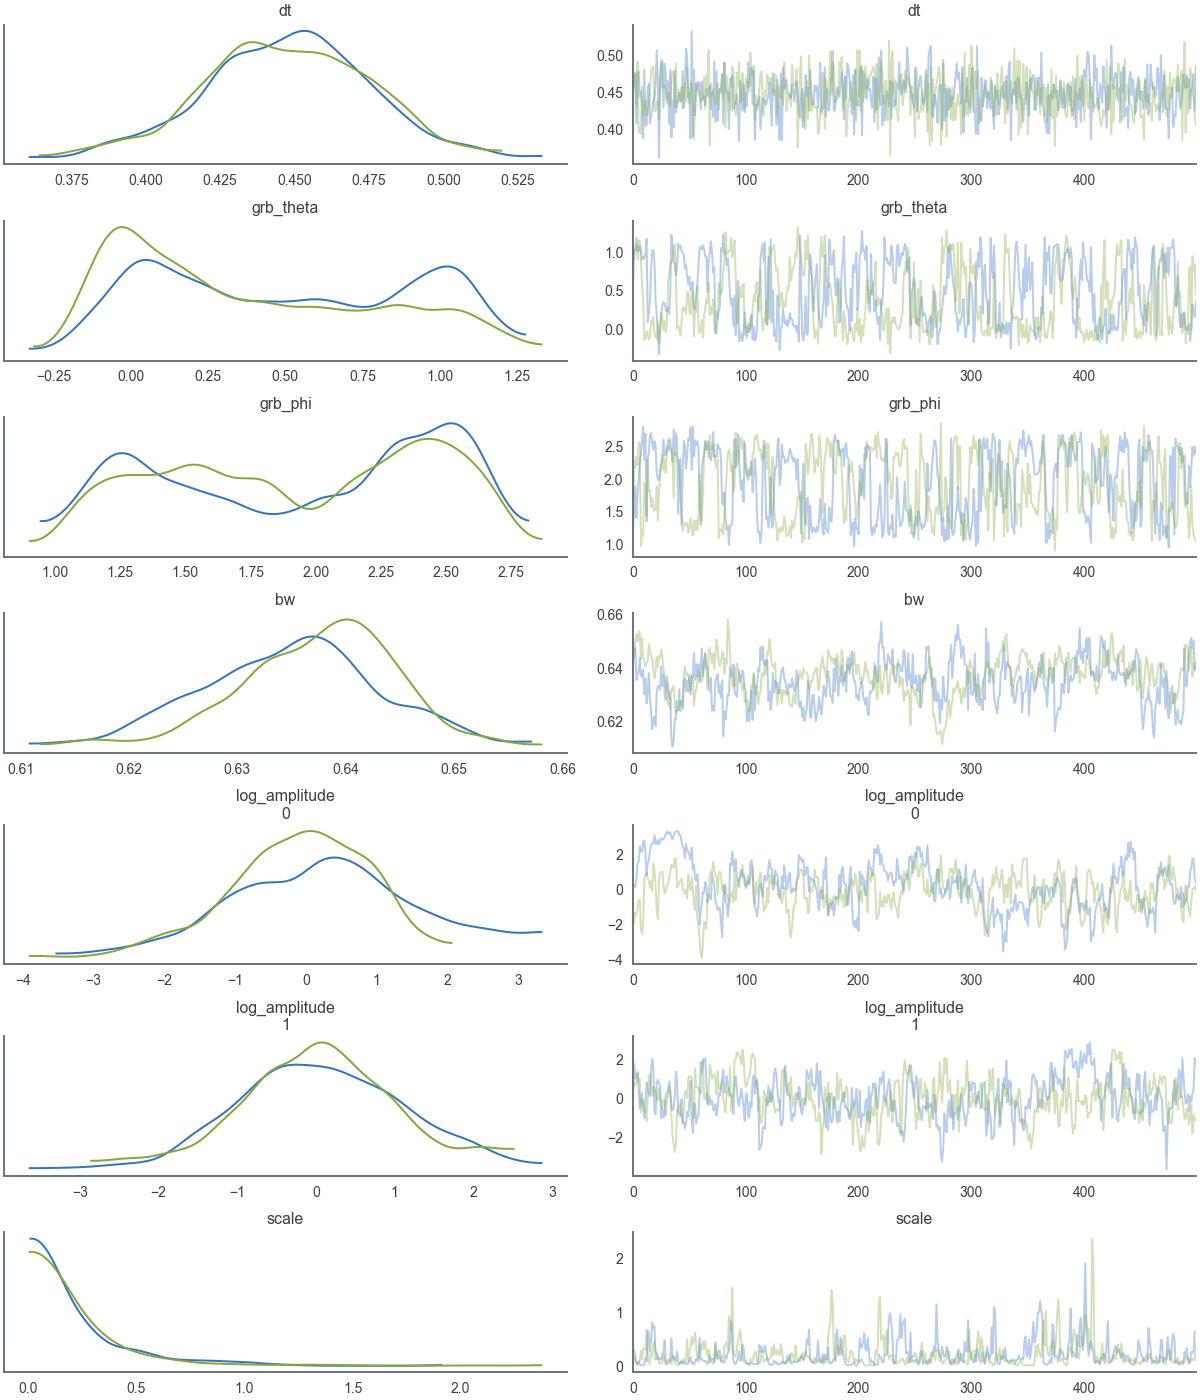

In [12]:

av.plot_trace(ar, [
              'dt',
              'grb_theta',
              'grb_phi',
              'bw',
              'log_amplitude',
              'scale'

             ]);

<IPython.core.display.Javascript object>


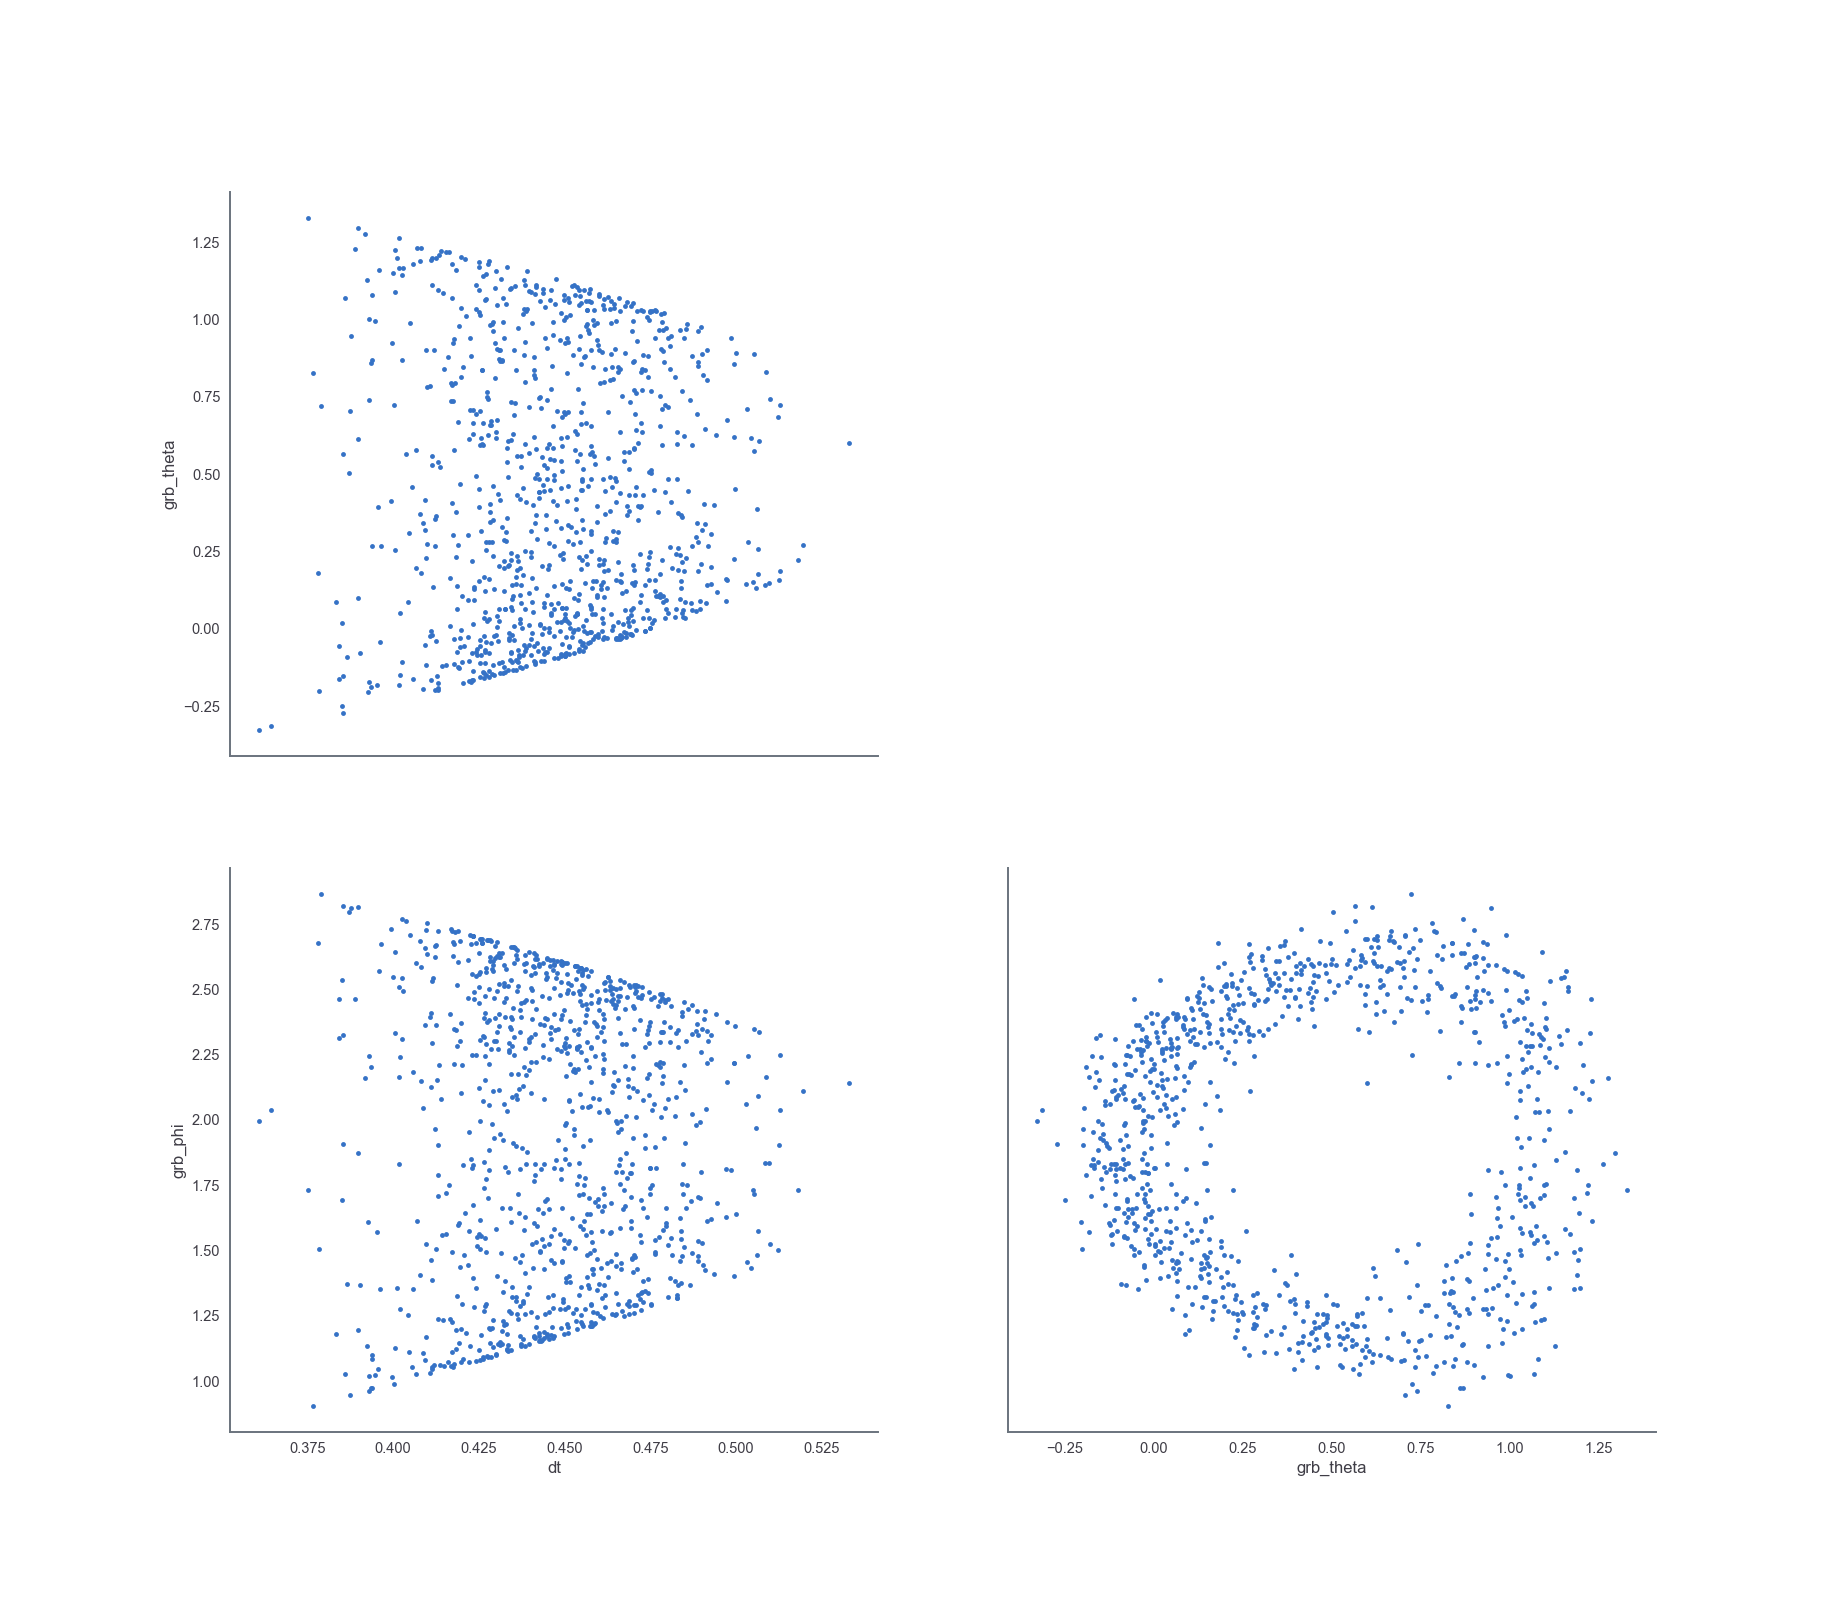

In [13]:
av.plot_pair(ar,var_names= [
              'dt',
              'grb_theta',
              'grb_phi',
 #             'bw',
             ]);

<IPython.core.display.Javascript object>


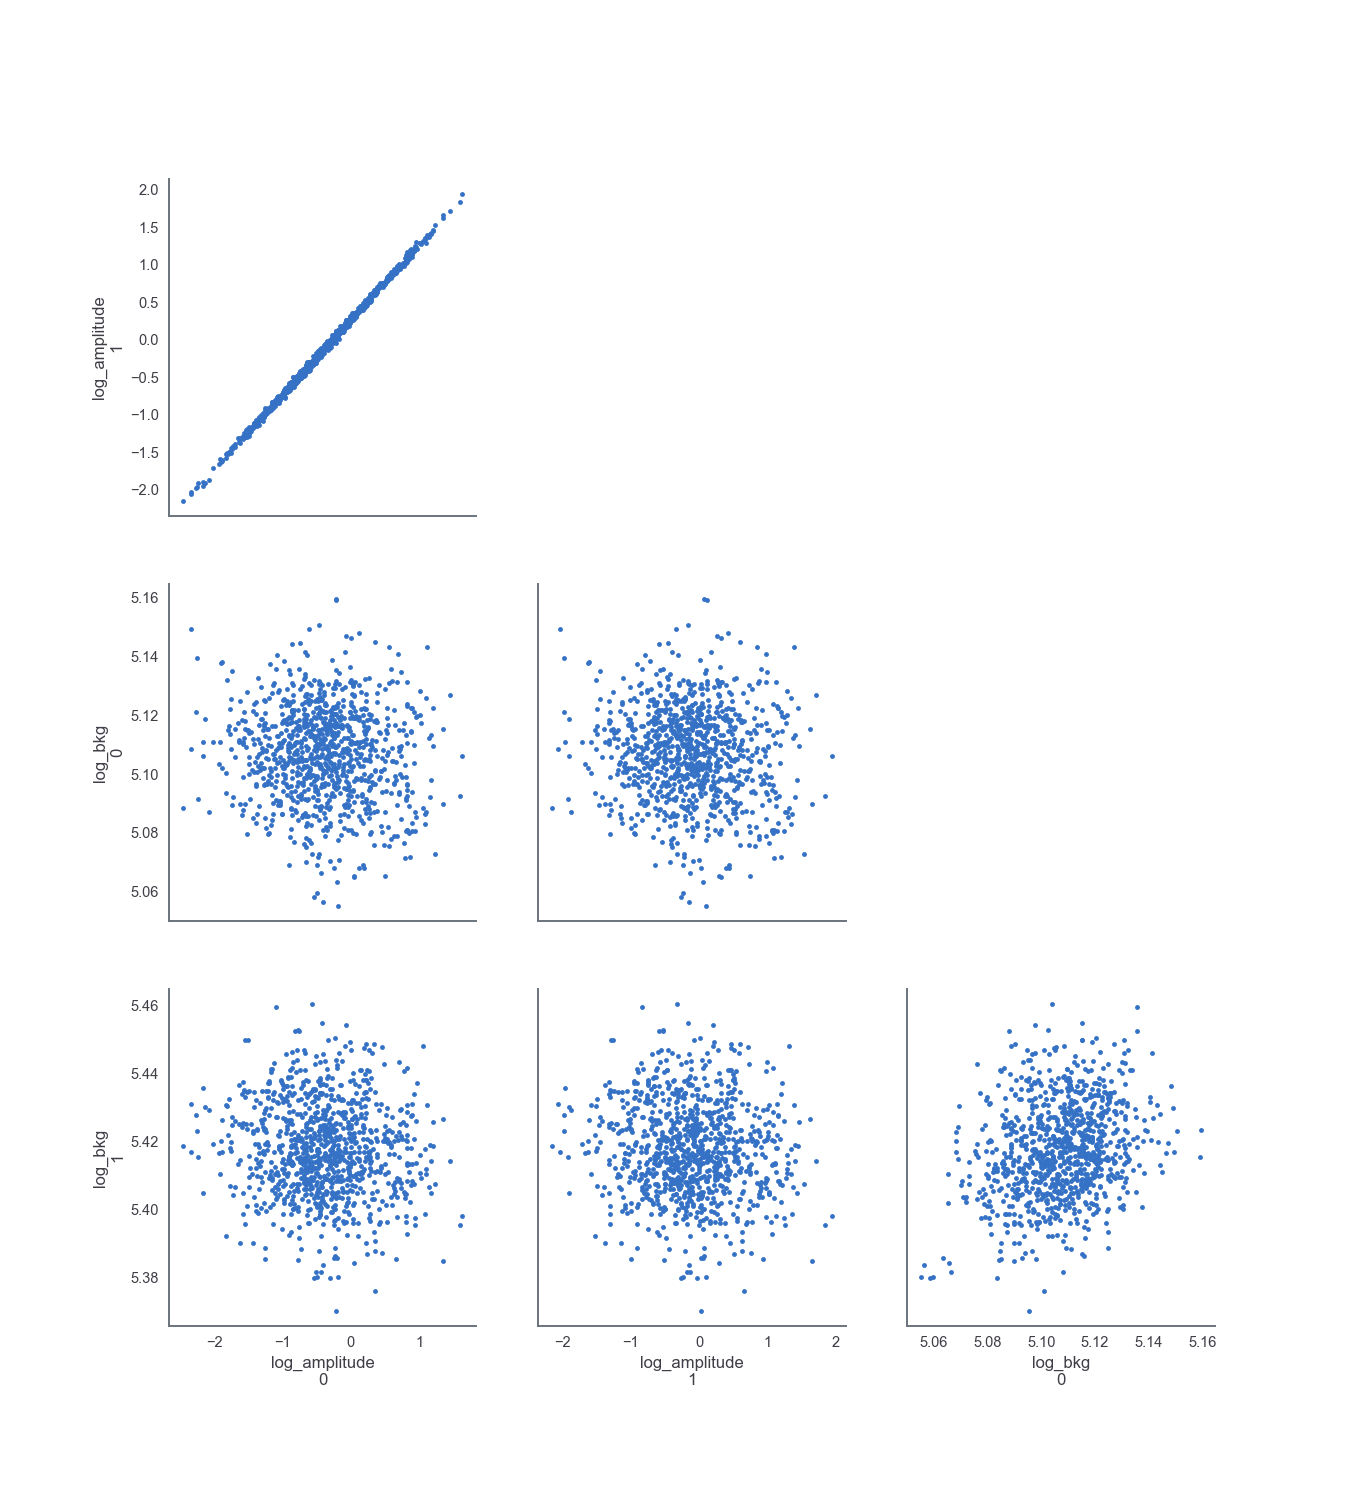

In [24]:
av.plot_pair(ar,var_names= [
              'log_amplitude',
    'log_bkg'
       
 #             'bw',
             ]);

<IPython.core.display.Javascript object>


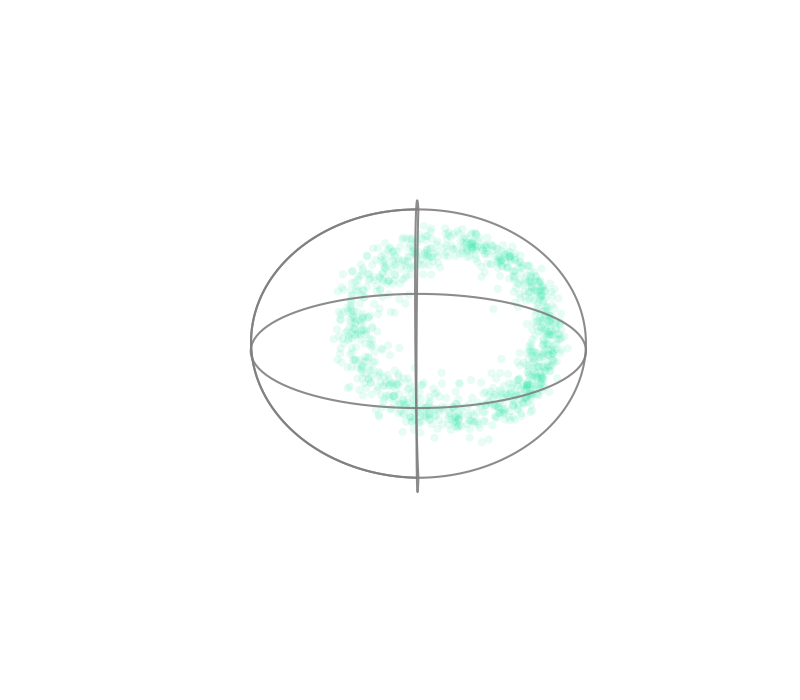

In [14]:
xyz = np.array(ar.posterior.grb_xyz).reshape(-1, ar.posterior.grb_xyz.shape[-1])
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
#xyz = nondivs['grb_xyz']


R=1

ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],c=green,alpha=.1,s=30, marker='o')


u1 = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x2 = R * np.outer(np.cos(u1), np.sin(v))
y2 = R * np.outer(np.sin(u1), np.sin(v))
z2 = R * np.outer(np.ones(np.size(u1)), np.cos(v))



ax.plot_wireframe(x2, y2, z2, color="grey", alpha=0.9, rcount=4, ccount=2)


ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax._axis3don = False
ax.pbaspect = [1.0, 1.0, 1.]


In [35]:
uni.plot_all_annuli(cmap='Set1',lw=3, threeD=True);
xyz = 1e6*np.array(ar.posterior.grb_xyz).reshape(-1, ar.posterior.grb_xyz.shape[-1])
ipv.scatter(xyz[:,0],xyz[:,1],xyz[:,2],marker="sphere", color="blue", size=.8)



Scatter(color=array('blue', dtype='<U4'), color_selected=array('white', dtype='<U5'), geo='sphere', line_mater…

In [31]:
ipv.scatter?

In [ ]:
rr

<IPython.core.display.Javascript object>


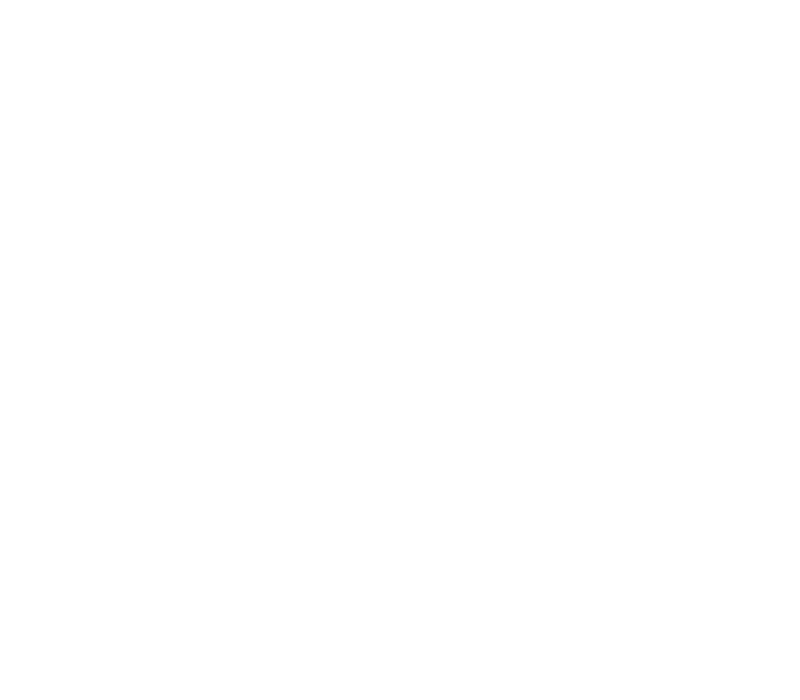

AttributeError: 'Dataset' object has no attribute 'fhat2'

In [40]:
fig, ax = plt.subplots()

fhat = np.array(ar.posterior.fhat2).reshape(-1, ar.posterior.fhat2.shape[-1])
bkg = np.array(ar.posterior.bkg).reshape(-1, ar.posterior.bkg.shape[-1])[:,1]

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid2, y, alpha=0.01, color=green)
    ax.plot(mid2, (y + b), alpha=0.01, color=red)
#    ax.plot(mid,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2/width2, edgecolor=yellow, facecolor="none", lw=0.9)

<IPython.core.display.Javascript object>


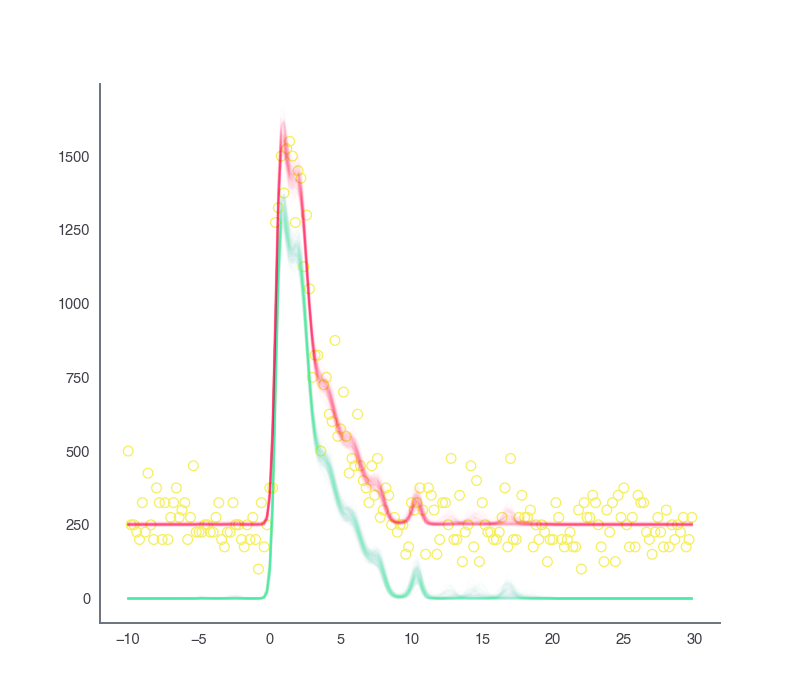

In [63]:
fig, ax = plt.subplots()

fhat = np.array(ar.posterior.fhat1).reshape(-1, ar.posterior.fhat1.shape[-1])
bkg = np.array(ar.posterior.bkg).reshape(-1, ar.posterior.bkg.shape[-1])[:,0]

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid, y, alpha=0.01, color=green)
    ax.plot(mid, (y + b), alpha=0.01, color=red)
#    ax.plot(mid,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts/width, edgecolor=yellow, facecolor="none", lw=0.9)

<IPython.core.display.Javascript object>


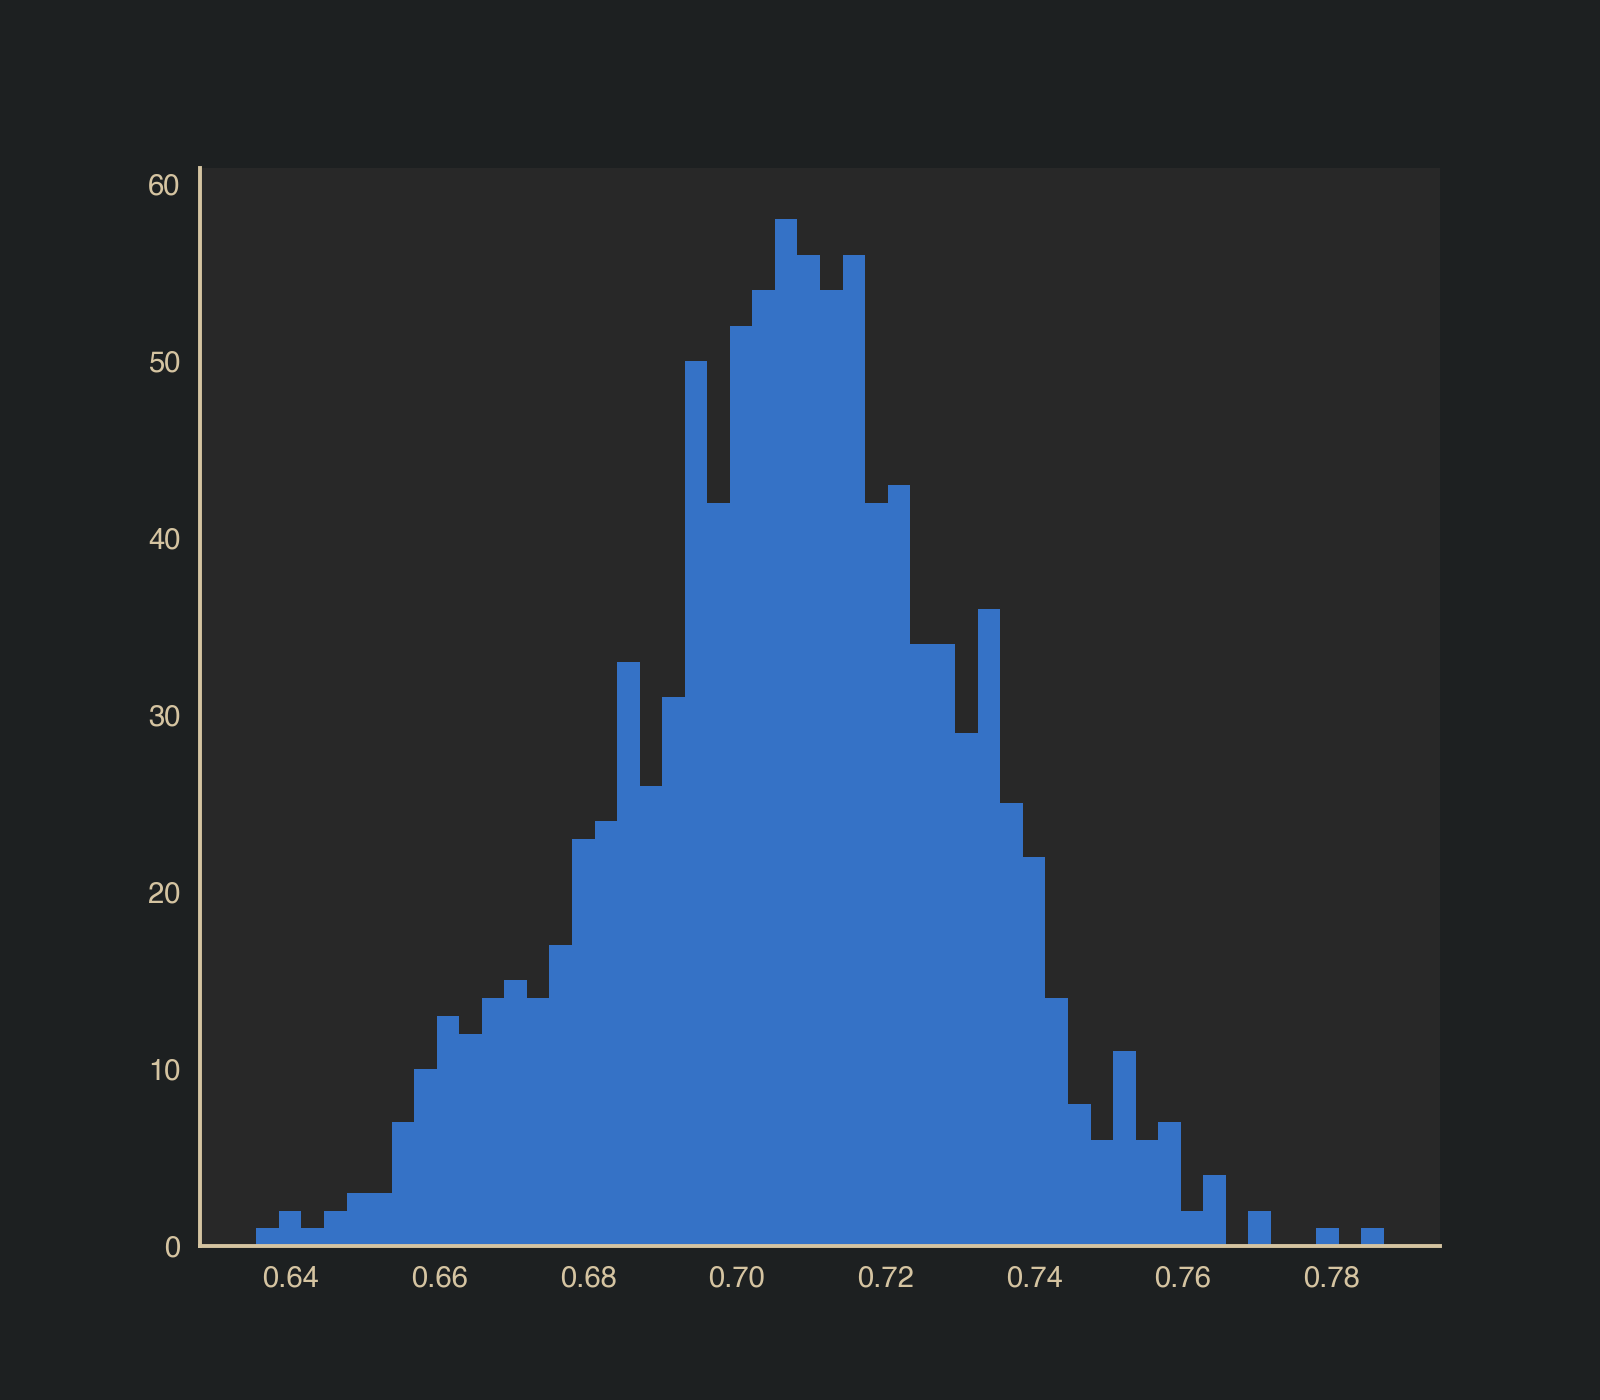

(array([ 1.,  2.,  1.,  2.,  3.,  3.,  7., 10., 13., 12., 14., 15., 14.,
        17., 23., 24., 33., 26., 31., 50., 42., 52., 54., 58., 56., 54.,
        56., 42., 43., 34., 34., 29., 36., 25., 22., 14.,  8.,  6., 11.,
         6.,  7.,  2.,  4.,  0.,  2.,  0.,  0.,  1.,  0.,  1.]),
 array([0.63534233, 0.63837618, 0.64141003, 0.64444388, 0.64747772,
        0.65051157, 0.65354542, 0.65657927, 0.65961311, 0.66264696,
        0.66568081, 0.66871466, 0.67174851, 0.67478235, 0.6778162 ,
        0.68085005, 0.6838839 , 0.68691775, 0.68995159, 0.69298544,
        0.69601929, 0.69905314, 0.70208698, 0.70512083, 0.70815468,
        0.71118853, 0.71422238, 0.71725622, 0.72029007, 0.72332392,
        0.72635777, 0.72939162, 0.73242546, 0.73545931, 0.73849316,
        0.74152701, 0.74456085, 0.7475947 , 0.75062855, 0.7536624 ,
        0.75669625, 0.75973009, 0.76276394, 0.76579779, 0.76883164,
        0.77186549, 0.77489933, 0.77793318, 0.78096703, 0.78400088,
        0.78703472]),
 <a list of 50

In [8]:
fig, ax = plt.subplots()

dt = fit.extract('dt')['dt']


ax.hist(dt,bins=50)

<IPython.core.display.Javascript object>


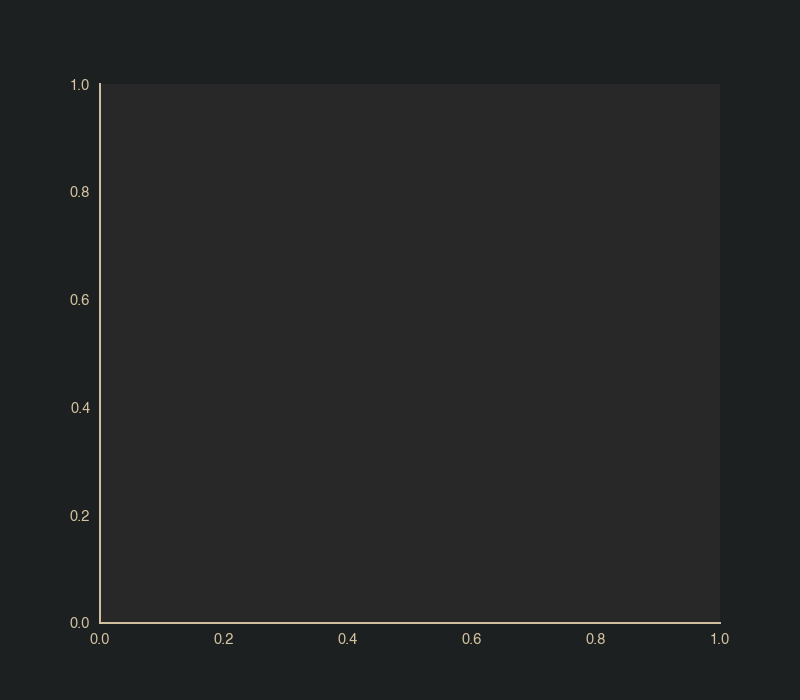

ValueError: No parameter ppc2

In [31]:
fig, ax = plt.subplots()

ppc2 = fit.extract('ppc2')['ppc2']


for p in ppc2[::10]:

    ax.scatter(mid2,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


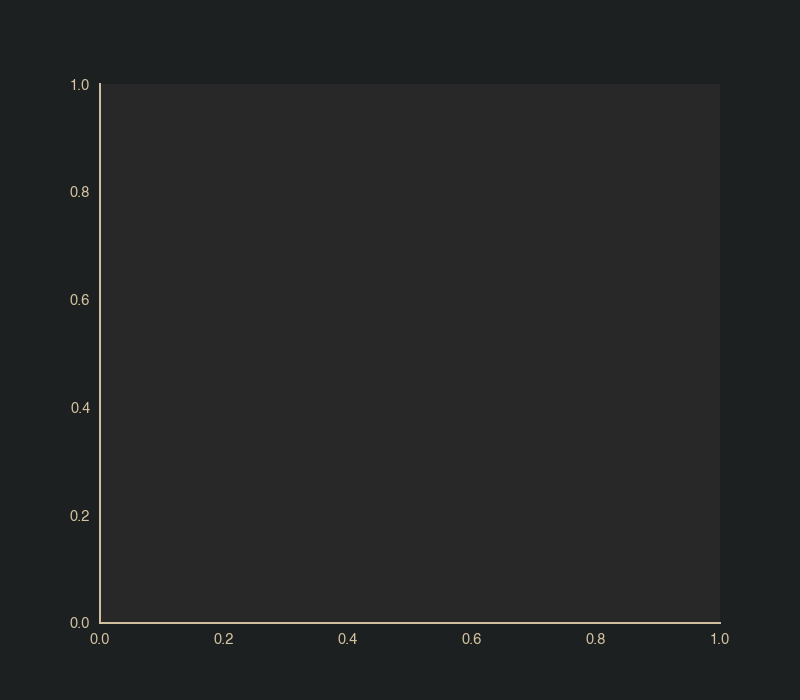

ValueError: No parameter ppc1

In [17]:
fig, ax = plt.subplots()

ppc1 = fit.extract('ppc1')['ppc1']


for p in ppc1[::10]:

    ax.scatter(mid,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


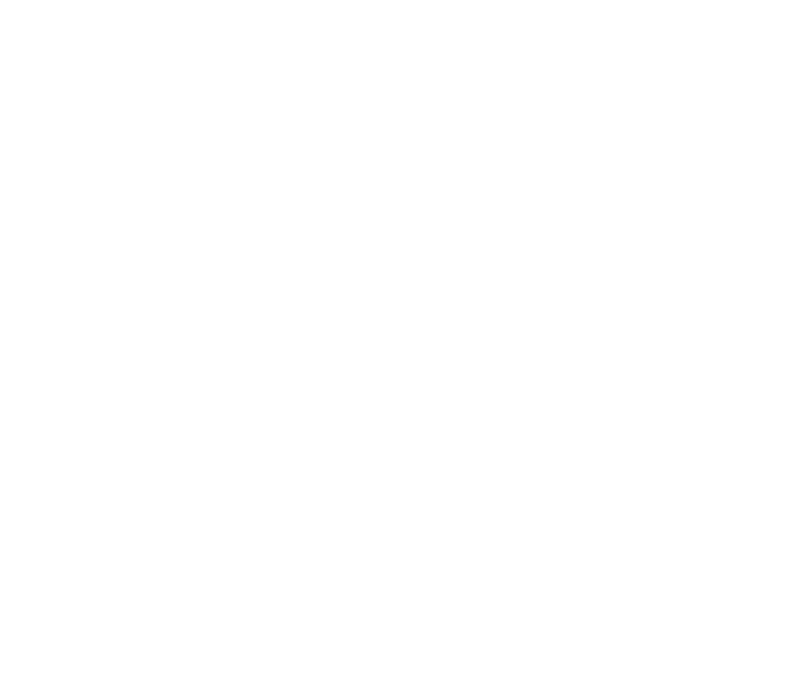

TypeError: unhashable type: 'SkyCoord'

In [16]:
fig, ax = plt.subplots(subplot_kw=dict(projection='astro globe',
                                       center=SkyCoord(105,20,unit='deg') ))

grb_theta = np.array(ar.posterior.grb_theta).reshape(-1, ar.posterior.grb_theta.shape[-1])
grb_phi = np.array(ar.posterior.grb_phi).reshape(-1, ar.posterior.grb_phi.shape[-1])



theta = np.rad2deg(grb_theta)
phi = np.rad2deg(grb_phi)



idx = phi <= 0

phi[idx] +=360


ax.scatter(phi, theta, c=green, alpha=.1,transform=ax.get_transform("icrs"),s=20)
ax.scatter(np.array([110.]),np.array([-3.]),c=red, s=40,transform=ax.get_transform("icrs"))



<IPython.core.display.Javascript object>


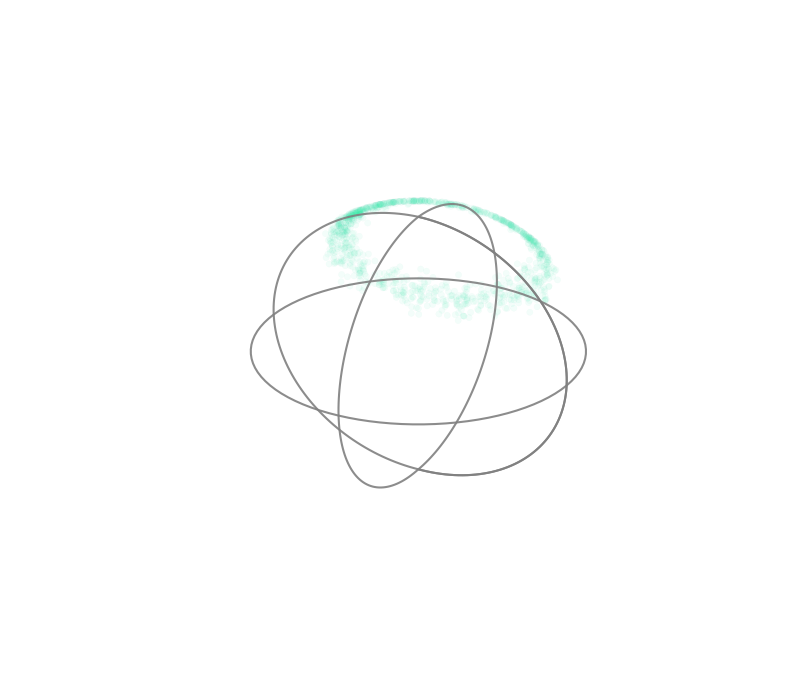

In [17]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
#xyz = fit.extract('grb_xyz')['grb_xyz']


R=1

ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],c=green,alpha=.05)

u1 = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x2 = R * np.outer(np.cos(u1), np.sin(v))
y2 = R * np.outer(np.sin(u1), np.sin(v))
z2 = R * np.outer(np.ones(np.size(u1)), np.cos(v))



ax.plot_wireframe(x2, y2, z2, color="grey", alpha=0.9, rcount=4, ccount=2)


ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax._axis3don = False



In [15]:

def compute_annulus_from_time_delay(time_delay, detector1, detector2, ax =None ,color=green,**kwargs):
    
    dxyz = (  detector2.location.get_cartesian_coord().xyz - detector1.location.get_cartesian_coord().xyz)
            
    dcart = Location(
    SkyCoord(
        x=dxyz[0],
        y=dxyz[1],
        z=dxyz[2],
        representation_type="cartesian",
        unit="km",
     #   frame='icrs'
    )
        )
    
    
    norm_d = dcart.get_norm_vec(u.km)
    
    distance = np.linalg.norm(dxyz) * u.km
    
    theta = np.arccos(
            np.around(((-const.c * time_delay*u.s ).to('km')/ distance).value, 15)
        )
    
    
    ra = dcart.coord.represent_as(UnitSphericalRepresentation).lon
    dec = dcart.coord.represent_as(UnitSphericalRepresentation).lat
    
    
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
    
    circle = SphericalCircle(
            np.array([ra.value, dec.value]) * ra.unit,
            theta*u.rad,
            vertex_unit=u.deg,
            resolution=5000,
            edgecolor=color,
            facecolor="none",
            transform=ax.get_transform("icrs"),
        **kwargs
       
  
        )
    
    
   
    
    ax.add_patch(circle)
    
    
    
    
    
    
    
    
    
    
    
    
    
    

In [12]:


for d in dt[::20]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det1'], detector2=uni.detectors['det2'], ax = ax )
    
    
    
ax.scatter(np.array([105.]),np.array([20.]),c=red, s=40,transform=ax.get_transform("icrs"))



/Users/jburgess/.environs/pyipn/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos
/Users/jburgess/.environs/pyipn/lib/python3.7/site-packages/astropy-3.2.1-py3.7-macosx-10.14-x86_64.egg/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/jburgess/.environs/pyipn/lib/python3.7/site-packages/astropy-3.2.1-py3.7-macosx-10.14-x86_64.egg/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/jburgess/.environs/pyipn/lib/python3.7/site-packages/astropy-3.2.1-py3.7-macosx-10.14-x86_64.egg/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/jburgess/.environs/pyipn/lib/python3.7/site-packages/astropy-3.2.1-py3.

ValueError: The first element of 'code' must be equal to 'MOVETO' (1)

In [13]:
fig2 = uni.plot_all_annuli(lw=3);


ax2 = fig2.get_axes()[0]
ax2.scatter(np.array([1.]),np.array([10.]),c=yellow, s=40,
            transform=ax.get_transform("icrs")
           )


for d in dt[::20]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det1'], detector2=uni.detectors['det2'], ax = ax2 )
    
    


<IPython.core.display.Javascript object>

/Users/jburgess/.environs/pyipn/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos


ValueError: The first element of 'code' must be equal to 'MOVETO' (1)

In [9]:
dt

array([0.72044715, 0.72134851, 0.72936298, 0.70425864, 0.68878105,
       0.69958128, 0.71168702, 0.72421236, 0.71001629, 0.68925441,
       0.64768047, 0.66858137, 0.67876437, 0.69811845, 0.69471117,
       0.73462606, 0.70891191, 0.6906104 , 0.7058728 , 0.72310396,
       0.70816087, 0.71065629, 0.73545573, 0.66163052, 0.72597172,
       0.71143225, 0.73714625, 0.72530848, 0.71404566, 0.70929417,
       0.72248268, 0.71599856, 0.70927522, 0.74673176, 0.70001904,
       0.69615852, 0.70400361, 0.69025919, 0.7006252 , 0.72992084,
       0.72591319, 0.71069744, 0.6901534 , 0.71174645, 0.70987126,
       0.69396407, 0.71057056, 0.72226159, 0.7385484 , 0.6813495 ,
       0.71184687, 0.71144424, 0.69092041, 0.73298293, 0.71896665,
       0.67647886, 0.71865197, 0.68030682, 0.6595529 , 0.71368737,
       0.66916035, 0.71649727, 0.69312149, 0.68237212, 0.69373647,
       0.76371741, 0.73971065, 0.70856238, 0.69508744, 0.67189278,
       0.67635948, 0.73254712, 0.70452085, 0.6884081 , 0.67416

In [14]:
fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))


compute_annulus_from_time_delay(.7, detector1=uni.detectors['det1'], detector2=uni.detectors['det2'], ax = ax )
    
   

<IPython.core.display.Javascript object>

/Users/jburgess/.environs/pyipn/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos


ValueError: The first element of 'code' must be equal to 'MOVETO' (1)

In [ ]:
uni._T0